In [1]:
import os
import sys
import logging
sys.path.append('.')
sys.path.append('..')
import argparse
import datetime as dt
import pickle
import yaml
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.data.imgproc import tf_read_image
from src.data.dataset import ImageDataset
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.multioutput import MultiOutputClassifier
from src.models.sklearn_models import models
from src.models.tensorflow_models import cnn_models
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, accuracy_score
from tensorflow.keras import mixed_precision
from keras import backend as K
from pandas.core.indexes import base
from datetime import datetime
from tensorflow.keras import mixed_precision

In [2]:
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060 SUPER, compute capability 7.5


In [3]:
os.path.realpath('..')
base_path = os.path.realpath('..')

In [4]:
cnn_pretrained = os.path.join(base_path, "models", "DenseNet121_keras_5_16_1_Random_1515_10082021.sav")

In [5]:
preprocessing_path = os.path.join(base_path, "config", "cnn_standard.yaml")
cnn_param_path = os.path.join(base_path, "config", "cnn_model.yaml")
image_path = os.path.join(base_path, "data", "raw")
data = os.path.join(base_path, "data", "raw", "CheXpert-v1.0-small", "valid.csv")
data_csv_path = os.path.join(base_path, "data", "raw", "CheXpert-v1.0-small", "valid.csv")
model_path = os.path.join(base_path, "models")
results_path = os.path.join(base_path, "reports", "figures")
limit = None
cnn_model = 'DenseNet121_keras'
cnn_transfer = False
frontal_only = False
batch_size = 1
return_labels = ['No Finding', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion', 'Support Devices']

In [6]:
process_cnn = True
map_option = 'Random'

In [7]:
with open(preprocessing_path, 'r') as file:
    preprocessing_config = yaml.full_load(file)
    transformations = preprocessing_config["transformations"]
with open(cnn_param_path, 'r') as file:
    cnn_param_config = yaml.full_load(file)

In [8]:
if process_cnn:
    allowed_transformations = ['crop', 'resize', 'eqhist', 'adaptive_eqhist', 'normalize']
else:
    allowed_transformations = ['crop', 'resize', 'eqhist', 'flatten', 'adaptive_eqhist',
                               'median_blur', 'gaussian_blur', 'normalize']

## Load Model

In [9]:
cnn_pretrained_path = os.path.join(base_path, "models", cnn_pretrained)
model = tf.keras.models.load_model(cnn_pretrained_path, compile=False)

In [10]:
model.summary()

Model: "DenseNet121_keras"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
densenet121 (Functional)        (None, None, None, 1 7037504     input_3[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           50          input_2[0][0]                    
__________________________________________________________________________________

## Load Data

In [11]:
test_transformations = [[key, val] for key,val in transformations if key in allowed_transformations]

dataset = ImageDataset(label_csv_path=data_csv_path, image_path_base=image_path, limit=limit,
                             transformations=test_transformations, map_option=map_option,
                             frontal_only=frontal_only)

## Select Data

In [12]:
selected_data = 'patient64711/study1/view1_frontal.jpg'
patient = 'patient64711'

In [13]:
df_dataset = dataset.df

In [14]:
#df_dataset = df_dataset[df_dataset['Path'].str.contains(selected_data)]
#df_dataset.reset_index(inplace=True)

In [15]:
df_dataset

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,C:\Users\songh\Google Drive\ISS610\chexpert-am...,1,0.73,1,1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C:\Users\songh\Google Drive\ISS610\chexpert-am...,1,0.70,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,C:\Users\songh\Google Drive\ISS610\chexpert-am...,1,0.70,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,C:\Users\songh\Google Drive\ISS610\chexpert-am...,1,0.85,1,1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,C:\Users\songh\Google Drive\ISS610\chexpert-am...,0,0.42,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,C:\Users\songh\Google Drive\ISS610\chexpert-am...,0,0.57,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
230,C:\Users\songh\Google Drive\ISS610\chexpert-am...,1,0.65,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
231,C:\Users\songh\Google Drive\ISS610\chexpert-am...,1,0.71,1,1,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
232,C:\Users\songh\Google Drive\ISS610\chexpert-am...,0,0.45,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
y_true = df_dataset[return_labels]
y_true.values

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.]])

In [17]:
tfds = tf.data.Dataset.from_tensor_slices((df_dataset[dataset._feature_header].values,
                                                 df_dataset['Path'].values, df_dataset[return_labels].values))


tfds = tfds.map(lambda x, y, z: tf_read_image(x, y, z, cnn_model=cnn_model,
                                                          transformations=test_transformations),
                            num_parallel_calls=tf.data.AUTOTUNE)


#required for batching
tfds = tfds.batch(batch_size)

#prefetch
tfds = tfds.prefetch(tf.data.AUTOTUNE)


In [18]:
y_test_multi = []
for x, test_label in tfds:
    for item in test_label:
        y_test_multi.append(item.numpy())

y_test_multi = np.array(y_test_multi)

## Model Prediction

In [19]:
y_pred_multi = model.predict(tfds, verbose=1, use_multiprocessing=True, workers=8)


234/234 [==============================] - 8s 23ms/step


In [20]:
list_to_plot = []
for idx, label in enumerate(return_labels):
    print (f"{label}: {y_pred_multi[0][idx] * 100} % {y_true.values[0][idx]}")
    if y_true.values[0][idx] == 1.0:
        list_to_plot.append((label, y_pred_multi[0][idx]))

No Finding: 50.5859375 % 0.0
Atelectasis: 40.3076171875 % 0.0
Cardiomegaly: 64.6484375 % 1.0
Consolidation: 22.03369140625 % 0.0
Edema: 41.4794921875 % 0.0
Pleural Effusion: 8.38623046875 % 0.0
Support Devices: 17.00439453125 % 0.0


In [21]:
list_to_plot

[('Cardiomegaly', 0.6465)]

## Evaluation Metric

In [22]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve, average_precision_score

In [23]:
print (return_labels[1:-1])

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']


<ipython-input-24-fb551ce7486d>:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot()
<ipython-input-24-fb551ce7486d>:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot()
<ipython-input-24-fb551ce7486d>:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be create

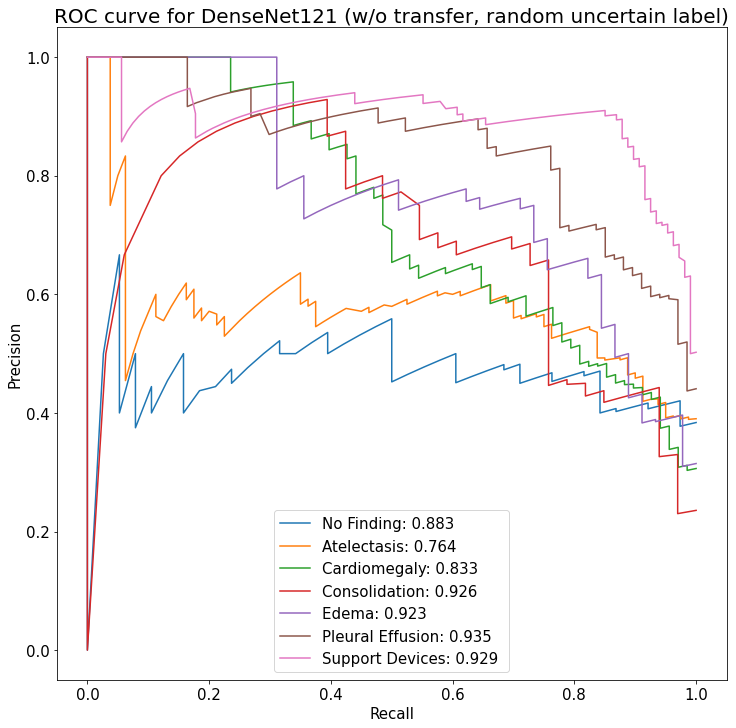

In [24]:
fig = plt.figure(figsize=(12, 12))
medical_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
non_medic_labels = ['No Finding', 'Support Devices']
for idx, label in enumerate(return_labels):
        if process_cnn:
            y_test = y_test_multi[:, idx]
            y_pred = y_pred_multi[:, idx]
        else:
            y_test = y_test_multi[label]
            y_pred = y_pred_multi[idx, :, 1]
            #y_pred_label = y_pred_labels[:, idx]
        y_pred_label = np.zeros(shape=y_pred.shape)
        auc = roc_auc_score(y_true=y_test, y_score=y_pred)
        precision, recall, pr_threshold = precision_recall_curve(y_true=y_test, probas_pred=y_pred)
        fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
        gmeans = np.sqrt(tpr * (1 - fpr))
        # locate the index of the largest g-mean
        ix = np.argmax(gmeans)
        # assign the prob above threshold to be label 1
        cutoff = thresholds[ix]
        y_pred_label[y_pred >= cutoff] = 1
        #calc accuracy and f1-score
        accuracy_dummy = accuracy_score(y_true=y_test, y_pred=np.ones(shape=y_pred.shape))
        accuracy = accuracy_score(y_true=y_test, y_pred=y_pred_label)
        f1 = f1_score(y_true=y_test, y_pred=y_pred_label)
        f1_dummy = f1_score(y_true=y_test, y_pred=np.ones(shape=y_pred.shape))
        ax = fig.add_subplot()
        ax.plot(recall, precision, label=f"{label}: %.3f " % (auc))
        ax.legend(fontsize=15)
        ax.tick_params(labelsize=15)
        ax.set_title(f"ROC curve for DenseNet121 (w/o transfer, random uncertain label)", fontsize=20)
        ax.set_xlabel("Recall", fontsize=15)
        ax.set_ylabel("Precision", fontsize=15)
        



(0.0, 1.01)

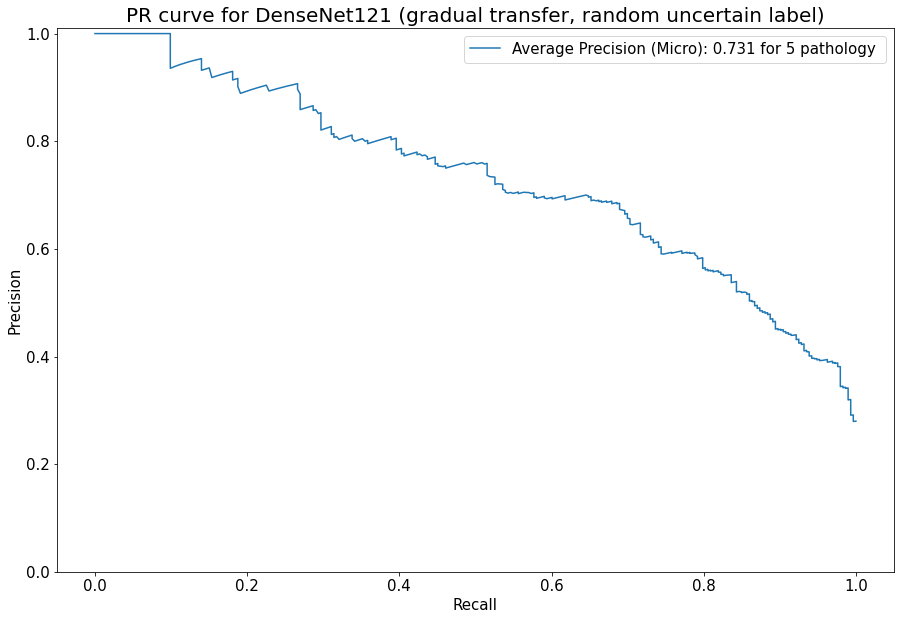

In [25]:
y_test_medical = y_test_multi[:, 1:-1]
y_pred_medical = y_pred_multi[:, 1:-1]
precision, recall, _ = precision_recall_curve(y_test_medical.ravel(), y_pred_medical.ravel())
avg = average_precision_score(y_test_medical, y_pred_medical, average="micro")
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()
ax.plot(recall, precision, label=f"Average Precision (Micro): %.3f for 5 pathology " % (avg))
ax.legend(fontsize=15)
ax.tick_params(labelsize=15)
ax.set_title(f"PR curve for DenseNet121 (gradual transfer, random uncertain label)", fontsize=20)
ax.set_xlabel("Recall", fontsize=15)
ax.set_ylabel("Precision", fontsize=15)
ax.set_ylim(bottom = 0, top = 1.01)
        

(0.0, 1.01)

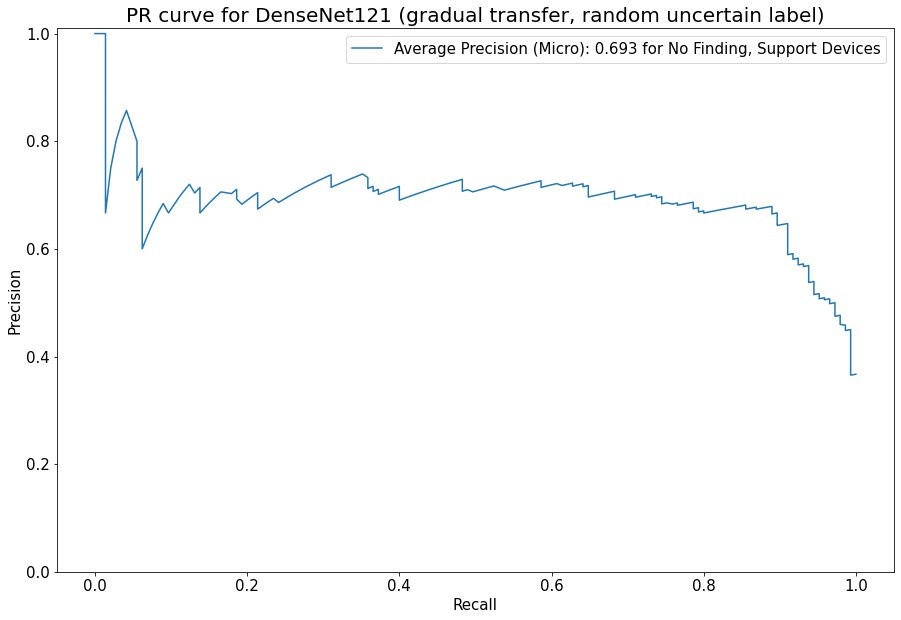

In [216]:
y_test_nomedic = y_test_multi[:, [0,-1]]
y_pred_nomedic  = y_pred_multi[:, [0,-1]]
precision, recall, _ = precision_recall_curve(y_test_nomedic.ravel(), y_pred_nomedic.ravel())
avg = average_precision_score(y_test_nomedic, y_pred_nomedic, average="micro")
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()
ax.plot(recall, precision, label=f"Average Precision (Micro): %.3f for No Finding, Support Devices" % (avg))
ax.legend(fontsize=15)
ax.tick_params(labelsize=15)
ax.set_title(f"PR curve for DenseNet121 (gradual transfer, random uncertain label)", fontsize=20)
ax.set_xlabel("Recall", fontsize=15)
ax.set_ylabel("Precision", fontsize=15)
ax.set_ylim(bottom = 0, top = 1.01)


(0.0, 1.01)

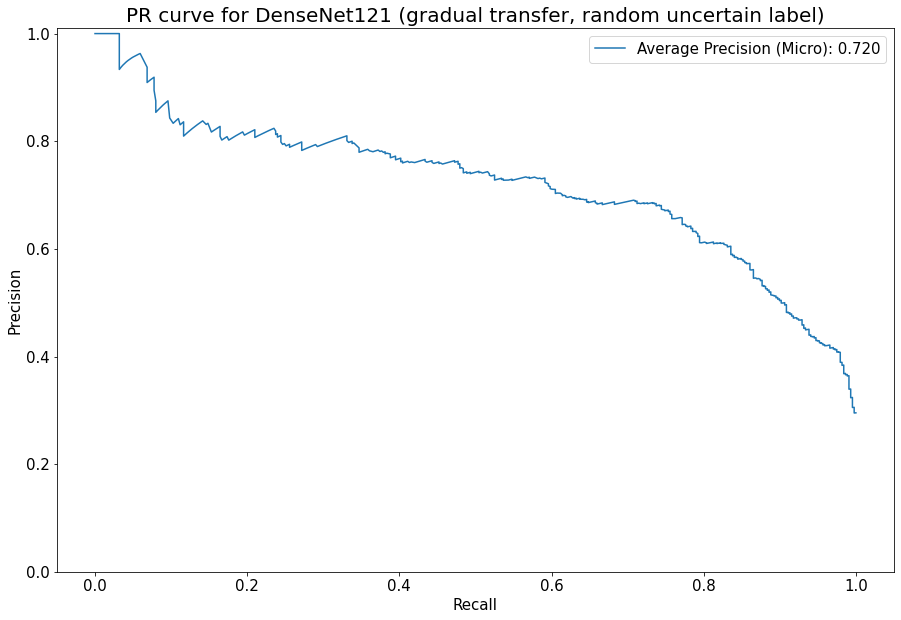

In [28]:
y_test_nomedic = y_test_multi[:, :]
y_pred_nomedic  = y_pred_multi[:, :]
precision, recall, _ = precision_recall_curve(y_test_nomedic.ravel(), y_pred_nomedic.ravel())
avg = average_precision_score(y_test_nomedic, y_pred_nomedic, average="micro")
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()
ax.plot(recall, precision, label=f"Average Precision (Micro): %.3f" % (avg))
ax.legend(fontsize=15)
ax.tick_params(labelsize=15)
ax.set_title(f"PR curve for DenseNet121 (gradual transfer, random uncertain label)", fontsize=20)
ax.set_xlabel("Recall", fontsize=15)
ax.set_ylabel("Precision", fontsize=15)
ax.set_ylim(bottom = 0, top = 1.01)


<ipython-input-29-29deefba0160>:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot()


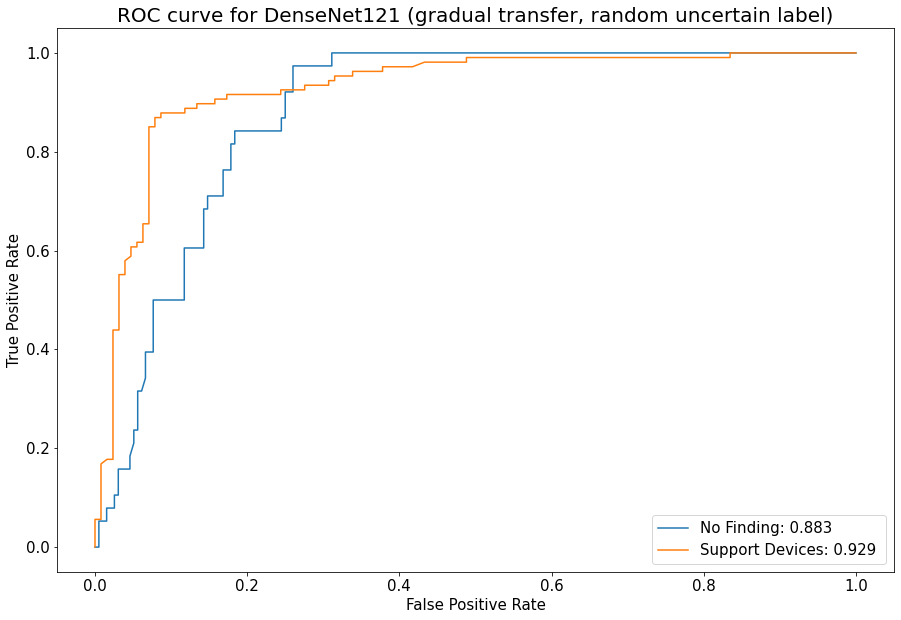

In [29]:
fig = plt.figure(figsize=(15, 10))
medical_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
non_medic_labels = ['No Finding', 'Support Devices']
for idx, label in enumerate(return_labels):
    if label in non_medic_labels:
        if process_cnn:
            y_test = y_test_multi[:, idx]
            y_pred = y_pred_multi[:, idx]
        else:
            y_test = y_test_multi[label]
            y_pred = y_pred_multi[idx, :, 1]
            #y_pred_label = y_pred_labels[:, idx]
        y_pred_label = np.zeros(shape=y_pred.shape)
        auc = roc_auc_score(y_true=y_test, y_score=y_pred)
        precision, recall, pr_threshold = precision_recall_curve(y_true=y_test, probas_pred=y_pred)
        fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
        gmeans = np.sqrt(tpr * (1 - fpr))
        # locate the index of the largest g-mean
        ix = np.argmax(gmeans)
        # assign the prob above threshold to be label 1
        cutoff = thresholds[ix]
        y_pred_label[y_pred >= cutoff] = 1
        #calc accuracy and f1-score
        accuracy_dummy = accuracy_score(y_true=y_test, y_pred=np.ones(shape=y_pred.shape))
        accuracy = accuracy_score(y_true=y_test, y_pred=y_pred_label)
        f1 = f1_score(y_true=y_test, y_pred=y_pred_label)
        f1_dummy = f1_score(y_true=y_test, y_pred=np.ones(shape=y_pred.shape))
        ax = fig.add_subplot()
        ax.plot(fpr, tpr, label=f"{label}: %.3f " % (auc))
        ax.legend(fontsize=15, loc='lower right')
        ax.tick_params(labelsize=15)
        ax.set_title(f"ROC curve for DenseNet121 (gradual transfer, random uncertain label)", fontsize=20)
        ax.set_xlabel("False Positive Rate", fontsize=15)
        ax.set_ylabel("True Positive Rate", fontsize=15)

<ipython-input-30-586b3c173468>:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot()
<ipython-input-30-586b3c173468>:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot()
<ipython-input-30-586b3c173468>:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be create

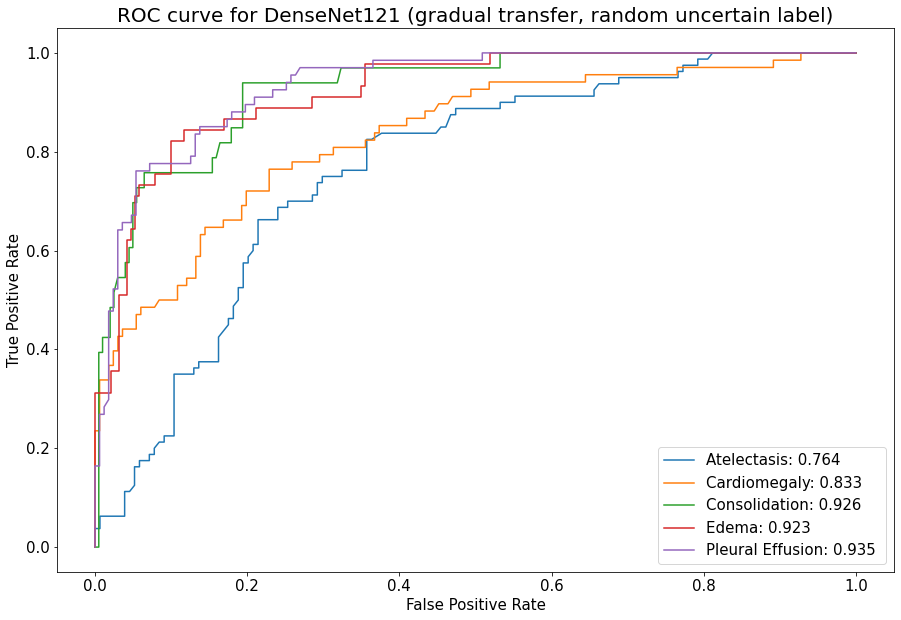

In [30]:
fig = plt.figure(figsize=(15, 10))
medical_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
non_medic_labels = ['No Finding', 'Support Devices']
for idx, label in enumerate(return_labels):
    if label in medical_labels:
        if process_cnn:
            y_test = y_test_multi[:, idx]
            y_pred = y_pred_multi[:, idx]
        else:
            y_test = y_test_multi[label]
            y_pred = y_pred_multi[idx, :, 1]
            #y_pred_label = y_pred_labels[:, idx]
        y_pred_label = np.zeros(shape=y_pred.shape)
        auc = roc_auc_score(y_true=y_test, y_score=y_pred)
        precision, recall, pr_threshold = precision_recall_curve(y_true=y_test, probas_pred=y_pred)
        fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
        gmeans = np.sqrt(tpr * (1 - fpr))
        # locate the index of the largest g-mean
        ix = np.argmax(gmeans)
        # assign the prob above threshold to be label 1
        cutoff = thresholds[ix]
        y_pred_label[y_pred >= cutoff] = 1
        #calc accuracy and f1-score
        accuracy_dummy = accuracy_score(y_true=y_test, y_pred=np.ones(shape=y_pred.shape))
        accuracy = accuracy_score(y_true=y_test, y_pred=y_pred_label)
        f1 = f1_score(y_true=y_test, y_pred=y_pred_label)
        f1_dummy = f1_score(y_true=y_test, y_pred=np.ones(shape=y_pred.shape))
        ax = fig.add_subplot()
        ax.plot(fpr, tpr, label=f"{label}: %.3f " % (auc))
        ax.legend(fontsize=15, loc='lower right')
        ax.tick_params(labelsize=15)
        ax.set_title(f"ROC curve for DenseNet121 (gradual transfer, random uncertain label)", fontsize=20)
        ax.set_xlabel("False Positive Rate", fontsize=15)
        ax.set_ylabel("True Positive Rate", fontsize=15)

<ipython-input-32-824e2ab7333f>:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot()
<ipython-input-32-824e2ab7333f>:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot()
<ipython-input-32-824e2ab7333f>:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be create

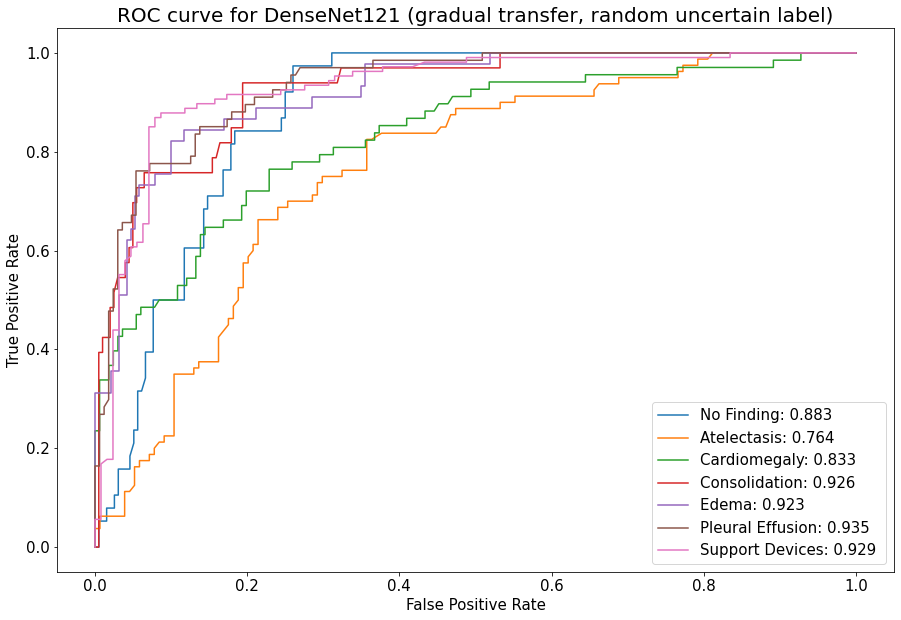

In [32]:
fig = plt.figure(figsize=(15, 10))
medical_labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion', 'No Finding', 'Support Devices']
for idx, label in enumerate(return_labels):
    if label in medical_labels:
        if process_cnn:
            y_test = y_test_multi[:, idx]
            y_pred = y_pred_multi[:, idx]
        else:
            y_test = y_test_multi[label]
            y_pred = y_pred_multi[idx, :, 1]
            #y_pred_label = y_pred_labels[:, idx]
        y_pred_label = np.zeros(shape=y_pred.shape)
        auc = roc_auc_score(y_true=y_test, y_score=y_pred)
        precision, recall, pr_threshold = precision_recall_curve(y_true=y_test, probas_pred=y_pred)
        fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
        gmeans = np.sqrt(tpr * (1 - fpr))
        # locate the index of the largest g-mean
        ix = np.argmax(gmeans)
        # assign the prob above threshold to be label 1
        cutoff = thresholds[ix]
        y_pred_label[y_pred >= cutoff] = 1
        #calc accuracy and f1-score
        accuracy_dummy = accuracy_score(y_true=y_test, y_pred=np.ones(shape=y_pred.shape))
        accuracy = accuracy_score(y_true=y_test, y_pred=y_pred_label)
        f1 = f1_score(y_true=y_test, y_pred=y_pred_label)
        f1_dummy = f1_score(y_true=y_test, y_pred=np.ones(shape=y_pred.shape))
        ax = fig.add_subplot()
        ax.plot(fpr, tpr, label=f"{label}: %.3f " % (auc))
        ax.legend(fontsize=15, loc='lower right')
        ax.tick_params(labelsize=15)
        ax.set_title(f"ROC curve for DenseNet121 (gradual transfer, random uncertain label)", fontsize=20)
        ax.set_xlabel("False Positive Rate", fontsize=15)
        ax.set_ylabel("True Positive Rate", fontsize=15)

## Visualisation

In [233]:
import os
import warnings
import cv2
import seaborn as sns
  
# ignoring all the warnings
warnings.simplefilter('ignore')
  
# import data handling libraries
import numpy as np
import pandas as pd
  
# importing data visualisation libraires
import matplotlib.pyplot as plt 
%matplotlib inline
  
    
# import image processing library
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2grey
from skimage.filters import gaussian
from skimage.transform import resize

In [234]:
for feat, lab in tfds.take(1):
    image_cnn = feat[1]

image_cnn = image_cnn[0, :, :, 0].numpy() * 255
image_cnn = image_cnn.astype(int)

[]

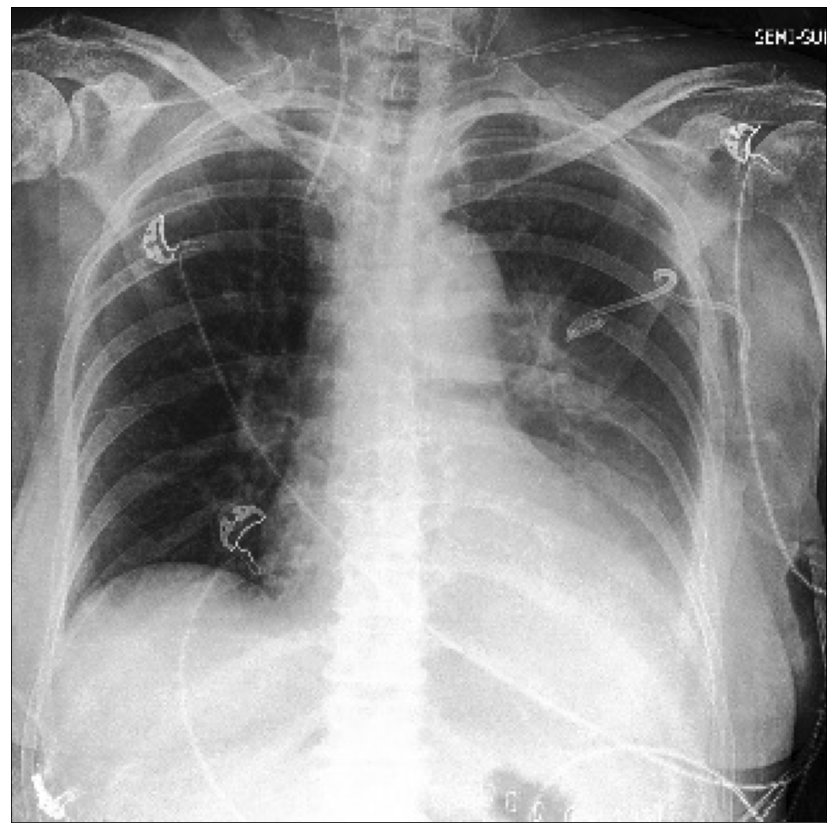

In [235]:
fig, ax= plt.subplots(figsize=(15,15))
img = cv2.imread(df_dataset.iloc[0]['Path'])
_ = ax.imshow(image_cnn, cmap='gray', vmin=0, vmax=255)
ax.set_xticks(())
ax.set_yticks(())

## Custom Code for Grad-Cam

In [236]:
model.summary()

Model: "DenseNet121_keras"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
densenet121 (Functional)        (None, None, None, 1 7037504     input_3[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           50          input_2[0][0]                    
__________________________________________________________________________________

In [238]:
model.layers[2].summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [257]:
last_conv_layer_name = ''
for layer in model.layers[::-1]:
    if 'global_average_pooling2d' in layer.name:
        last_conv_layer_name = layer.name
        print (last_conv_layer_name)
        break

global_average_pooling2d


In [240]:
model.inputs

[<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 320, 320, 3) dtype=float32 (created by layer 'input_3')>]

In [188]:
model.layers[2].get_layer(last_conv_layer_name).output

<KerasTensor: shape=(None, None, None, 32) dtype=float16 (created by layer 'conv5_block16_2_conv')>

In [189]:
model.layers[-2].output

<KerasTensor: shape=(None, 7) dtype=float16 (created by layer 'dense_1')>

In [253]:
model.layers[2].inputs

[<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>]

In [262]:
grad_model = tf.keras.models.Model(
    [model.inputs], [model.get_layer('global_average_pooling2d').input, model.layers[-2].output]
)

In [263]:
list_heatmap = []
for idx, label in enumerate(return_labels):
    if y_true.values[0][idx] == 1:
        # Then, we compute the gradient of the top predicted class for our input image
        # with respect to the activations of the last conv layer
        with tf.GradientTape() as tape:
            last_conv_layer_output, preds = grad_model(feat)
            grads = tape.gradient(preds[:, idx], last_conv_layer_output)
            
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        # For visualization purpose, we will also normalize the heatmap between 0 & 1
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        list_heatmap.append(heatmap.numpy().astype('float32'))

Text(0.5, 0.95, 'Grad-CAM for patient64711')

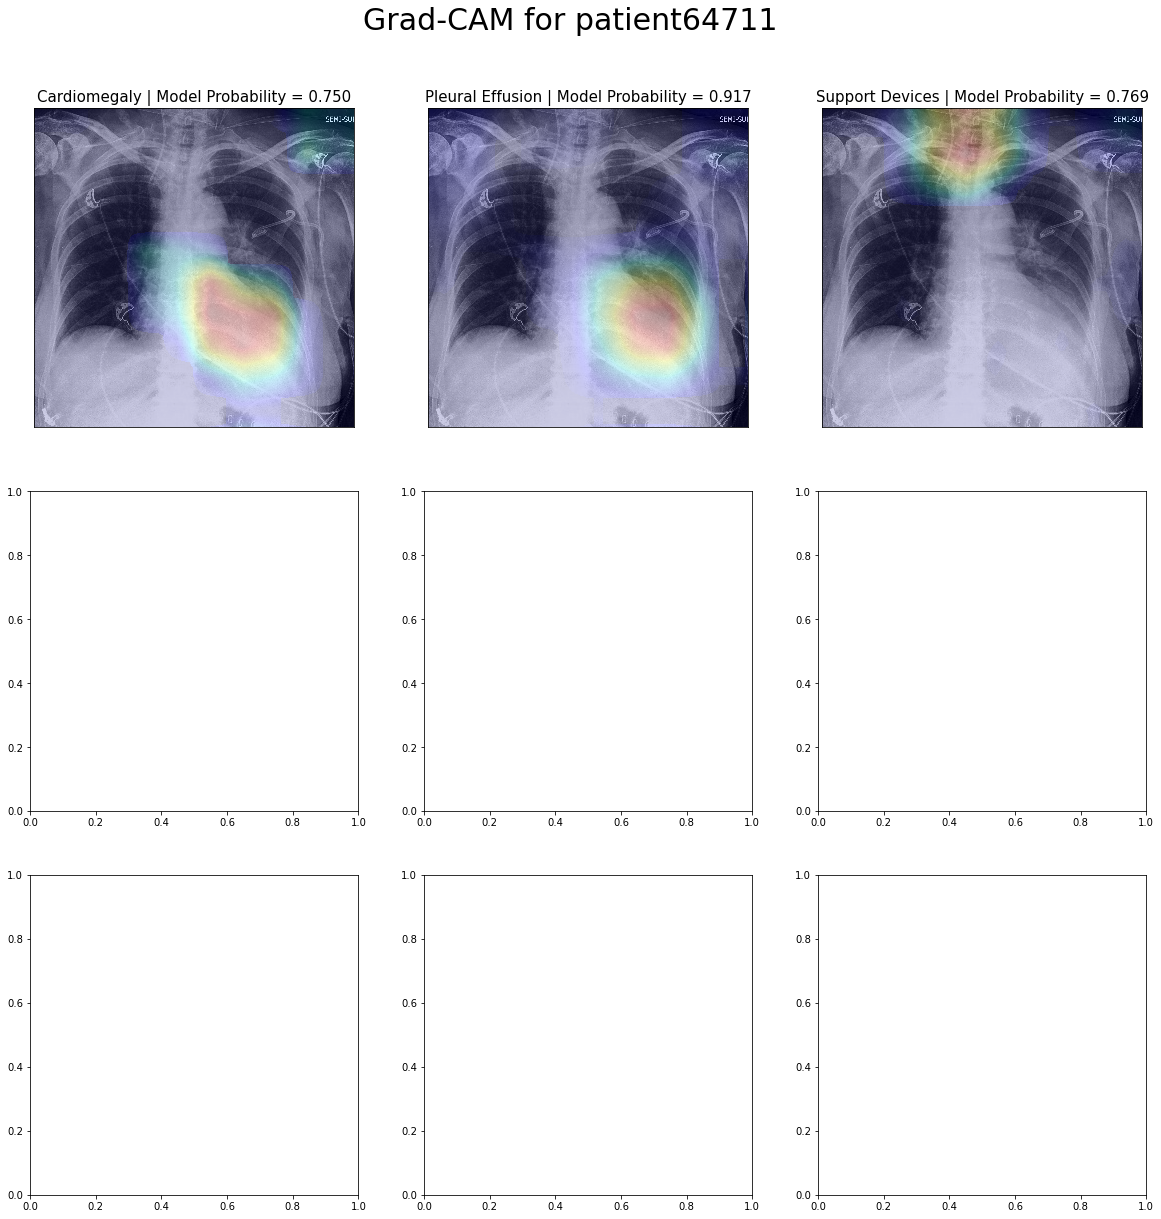

In [267]:
row, col = 3, 3
alpha = 0.2
extent = 0, image_cnn.shape[1], 0, image_cnn.shape[1]
fig, axes = plt.subplots(3, 3, figsize=(20,20))
for i in range(len(list_heatmap)):
    
    r = i // row
    c = i % col
    # Rescale heatmap to a range 0-255
    heatmap_resize = resize(list_heatmap[i], output_shape=(image_cnn.shape[1], image_cnn.shape[0]))
    heatmap_resize[np.where(heatmap_resize < 0.01)] = np.nan
    heatmap_gaussian = np.uint8(255 * gaussian(heatmap_resize, sigma=3))

    my_cmap = plt.cm.jet

    _ = axes[r][c].imshow(image_cnn, cmap='gray', vmin=0, vmax=255, extent=extent)
    _ = axes[r][c].imshow(heatmap_gaussian, cmap=my_cmap, vmin=0, vmax=255, 
                          alpha=alpha, extent=extent, interpolation='none')
    axes[r][c].set_xticks(())
    axes[r][c].set_yticks(())
    label, prob = list_to_plot[i]
    axes[r][c].set_title(f"{label} | Model Probability = %.3f" % (prob), fontsize=15)

plt.figtext(0.5, 0.95, f'Grad-CAM for {patient}', ha='center', va='top', fontsize=30)

## PCA Model Interpretation

In [309]:
pca_pretrained = "IncrementalPCA_200_500_U-zero_0752_30072021.sav"
pca_n = 200
pca_f_path = os.path.join(base_path, "models", pca_pretrained)
with open(pca_f_path, 'rb') as file:
    pca = pickle.load(file)

In [310]:
eigenlung = pca.components_.reshape((-1, 320, 320))

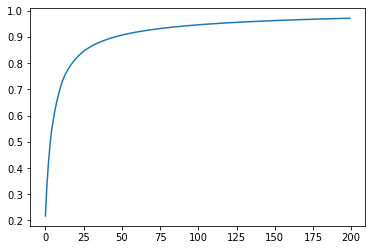

In [311]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [312]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
eigenlung_titles = ["Eigenlung %d" % i for i in range(eigenlung.shape[0])]

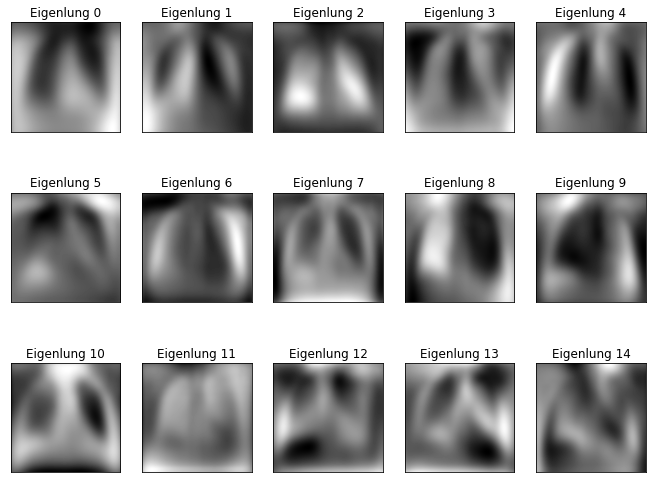

In [313]:
plot_gallery(eigenlung, eigenlung_titles, 320, 320)

In [288]:
from src.data.dataset import ImageDataset
pca_csv_path = os.path.join(base_path, "data", "raw", "CheXpert-v1.0-small", "train.csv")
pca_dataset = ImageDataset(label_csv_path=pca_csv_path, image_path_base=image_path, limit=limit,
                             transformations=test_transformations, map_option=map_option,
                             frontal_only=frontal_only)
x_features_test, x_image_test, y_test_multi = pca_dataset[800]

In [290]:
reconstruct = np.array(pca.components_[0].shape)
final = pca.components_ * pca.transform(x_image_test.flatten().reshape(1,-1))[0].reshape(1000, 1)

In [291]:
e = pca.transform(x_image_test.flatten().reshape(1,-1))

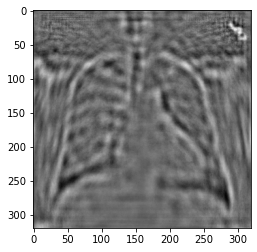

In [292]:
plt.imshow(final.sum(axis=0).reshape(320,320), cmap='gray')

In [293]:
np.argsort(pca.transform(x_image_test.flatten().reshape(1,-1)))[0][::-1]

array([ 67, 224,  84, 817, 632, 290, 573, 834, 986, 602, 244, 930, 596,
       292, 358, 163, 766, 617, 841, 682, 462, 718, 999, 940, 460, 518,
       627, 450,  78, 429, 725, 598,  53, 569, 440, 195, 488, 804, 697,
       136, 552, 944, 578, 595, 738, 980, 332, 984, 105,  49, 313, 110,
        58, 139, 866, 414, 776, 534, 714, 126, 294,  31, 549, 852,  54,
       297, 997, 671, 219, 922, 491, 945, 319, 541, 328, 188, 409, 204,
       645, 893, 731, 872, 643, 806, 370, 657, 564, 900, 438, 437, 246,
       898, 404, 737, 894, 497, 871, 985, 382, 701, 366, 211, 888, 227,
       419, 129, 175, 576, 267, 464, 820, 318, 562, 947, 809, 279, 343,
       566, 314, 325, 532, 232, 522,  20, 678, 208, 881, 458, 141, 556,
       700, 789, 570, 733, 915, 299, 873, 447, 264, 442, 400, 241, 482,
       743, 215, 849, 658, 535,  66, 468, 479, 816, 728, 338, 621, 696,
       191, 517, 431, 372, 811, 734, 929, 901, 295, 167, 571, 542,  15,
       310, 467, 575, 280, 842, 759, 974, 778, 361, 526, 540, 25

In [294]:
y_test_multi

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [295]:
pca_dataset._label_header

Index(['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices'],
      dtype='object')

In [296]:
x_image_test.flatten().reshape(1,-1)

array([[0.08627451, 0.08235294, 0.07450981, ..., 0.42352942, 0.40392157,
        0.45882353]], dtype=float32)

In [297]:
np.argsort(np.abs(pca.transform(x_image_test.flatten().reshape(1,-1))))[0][::-1]

array([659,  67, 224, 301, 376, 181,  84, 817, 632, 145, 290, 936, 573,
       834, 515, 662,  68, 395, 986, 602, 244, 930, 397, 832, 109,  42,
       596, 292, 358, 163, 766, 617, 198, 841, 830, 682, 230, 462, 939,
       718, 594, 932, 999, 234, 443, 202, 940, 608,  35, 460, 963, 518,
       627, 450, 394,  78, 429, 931, 879, 378, 884, 725, 846, 972, 598,
       663, 828, 705, 609, 240, 814, 933,  53, 569, 130, 440, 195, 858,
       488, 465, 355, 804, 697, 574, 504, 597, 568, 902, 768, 136, 552,
       944, 578, 427, 565, 954, 595, 396, 738, 980, 303, 788, 847, 332,
       984, 521, 708, 105, 384, 843, 636,  49, 287, 313, 628, 110,  58,
       139, 761, 866, 414, 103, 242, 742, 399, 776, 534, 714, 126, 317,
       294,  31, 549, 852, 123,  54, 807, 315,  75, 356, 297, 997, 825,
       257, 336, 671, 219, 392, 922, 491, 176, 962, 945, 319, 541, 328,
       188, 177, 409, 108, 204, 346, 268, 645, 893,  91, 731, 872, 585,
       643, 806, 370, 657, 564, 900, 487, 438, 791, 525, 531, 43

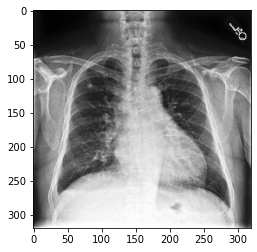

In [298]:
plt.imshow(x_image_test, cmap='gray')